In [ ]:
import numpy as np
import wfdb
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import matplotlib.pyplot as plt

# Define the ECGDataset class
class ECGDataset(Dataset):
    def __init__(self, raw_signals, noisy_signals):
        self.raw_signals = raw_signals
        self.noisy_signals = noisy_signals

    def __len__(self):
        return len(self.raw_signals)

    def __getitem__(self, idx):
        raw_signal = self.raw_signals[idx]
        noisy_signal = self.noisy_signals[idx]
        return torch.tensor(raw_signal, dtype=torch.float32), torch.tensor(noisy_signal, dtype=torch.float32)

# Define the add_noise function
def add_noise(signal, noise, snr):
    signal_power = np.mean(signal ** 2)
    noise_power = np.mean(noise ** 2)
    factor = (signal_power / noise_power) / (10 ** (snr / 10))
    noisy_signal = signal + noise * 100 * np.sqrt(factor)
    return noisy_signal

# Define the load_mit_bih_data function
def load_mit_bih_data(records, noise_type, snr_levels, target_length=650000):
    raw_signals = []
    noisy_signals_dict = {snr: [] for snr in snr_levels}
    
    for record in records:
        raw_record = wfdb.rdrecord(f'C:\\Users\\malik\\Desktop\\Disertation\\New folder\\mit-bih-arrhythmia-database-1.0.0/{record}')
        raw_signal = raw_record.p_signal[:, 0]  # Use the first channel for simplicity
        
        # Load noise and add it to the raw signal
        noise_record = wfdb.rdrecord(f'C:\\Users\\malik\\Desktop\\Disertation\\New folder\\mit-bih-noise-stress-test-database-1.0.0/{noise_type}')
        noise_signal = noise_record.p_signal[:, 0]
        
        # Ensure the signals are of the same length
        min_length = min(len(raw_signal), len(noise_signal), target_length)
        raw_signal = raw_signal[:min_length]
        noise_signal = noise_signal[:min_length]
        
        # Pad signals to target length
        if min_length < target_length:
            raw_signal = np.pad(raw_signal, (0, target_length - min_length), 'constant')
            noise_signal = np.pad(noise_signal, (0, target_length - min_length), 'constant')
        
        raw_signals.append(raw_signal)
        
        for snr in snr_levels:
            noisy_signal = add_noise(raw_signal, noise_signal, snr)
            noisy_signals_dict[snr].append(noisy_signal)
    
    return np.array(raw_signals), {snr: np.array(noisy_signals_dict[snr]) for snr in snr_levels}

# Select records and noise types for the experiment
records = ['103', '105', '111', '116', '122', '205', '213', '219', '223', '230']
noise_types = ['bw', 'em', 'ma']
combined_noise_types = ['em+bw', 'ma+bw', 'ma+em', 'ma+em+bw']
snr_levels = [0, 1, 2, 3, 4, 5]
target_length = 649984

raw_signals, noisy_signals_dict = {}, {}
for noise_type in noise_types:
    raw_signals[noise_type], noisy_signals_dict[noise_type] = load_mit_bih_data(records, noise_type, snr_levels, target_length)

# For combined noise types, combine the corresponding noises
for combined_noise in combined_noise_types:
    components = combined_noise.split('+')
    combined_raw_signals, combined_noisy_signals = [], {snr: [] for snr in snr_levels}
    for i in range(len(records)):
        combined_signal = np.zeros(target_length)
        for component in components:
            raw_signal = raw_signals[component][i]
            combined_signal += raw_signal / len(components)  # Average the signals
        combined_raw_signals.append(combined_signal)
        for snr in snr_levels:
            combined_noise_signal = np.zeros(target_length)
            for component in components:
                noise_signal = noisy_signals_dict[component][snr][i]
                combined_noise_signal += noise_signal / len(components)  # Average the noises
            combined_noisy_signals[snr].append(combined_noise_signal)
    raw_signals[combined_noise] = np.array(combined_raw_signals)
    noisy_signals_dict[combined_noise] = {snr: np.array(combined_noisy_signals[snr]) for snr in snr_levels}

# Create datasets and dataloaders
datasets = {}
for noise_type in noise_types + combined_noise_types:
    for snr in snr_levels:
        datasets[(noise_type, snr)] = ECGDataset(raw_signals[noise_type], noisy_signals_dict[noise_type][snr])

dataloaders = {key: DataLoader(dataset, batch_size=16, shuffle=True) for key, dataset in datasets.items()}

# Define the Generator class
class Generator(nn.Module):
    def __init__(self, use_z=True):
        super(Generator, self).__init__()
        self.use_z = use_z
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 8, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(8, 16, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(16, 32, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(512, 1024, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.decoder_with_z = nn.Sequential(
            nn.ConvTranspose1d(2048, 1024, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(1024, 512, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(16, 8, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(8, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )
        self.decoder_without_z = nn.Sequential(
            nn.ConvTranspose1d(1024, 512, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(16, 8, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(8, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        if self.use_z:
            z = torch.randn_like(encoded)
            encoded = torch.cat((encoded, z), 1)
            decoded = self.decoder_with_z(encoded)
        else:
            decoded = self.decoder_without_z(encoded)
        return decoded

# Define the Discriminator class
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv1d(2, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(512, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x).view(x.size(0), -1)

# Define the calculate_snr function
def calculate_snr(original, denoised):
    noise = original - denoised
    snr = 10 * np.log10(np.sum(original ** 2) / np.sum(noise ** 2))
    return snr

def calculate_rmse(original, denoised):
    mse = np.mean((original - denoised) ** 2)
    rmse = np.sqrt(mse)
    return rmse

def train(generator, discriminator, dataloaders, num_epochs=1, lr=0.0005):
    criterion = nn.BCELoss()
    optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    results = {'Noise_Type': [], 'SNR_Level': [], 'Epoch': [], 'Batch': [], 'D_loss': [], 'G_loss': [], 'SNR': [], 'RMSE': []}
    
    for (noise_type, snr), dataloader in dataloaders.items():
        for epoch in range(num_epochs):
            for i, (raw_signals, noisy_signals) in enumerate(dataloader):
                batch_size = raw_signals.size(0)
                
                # Ensure the signals have the same length
                min_length = min(raw_signals.shape[-1], noisy_signals.shape[-1])
                raw_signals = raw_signals[:, :min_length]
                noisy_signals = noisy_signals[:, :min_length]

                # Denoise the noisy signals
                noisy_signals = noisy_signals.unsqueeze(1)  # Add channel dimension
                raw_signals = raw_signals.unsqueeze(1)

                # Train Generator
                optimizer_G.zero_grad()
                gen_signals = generator(noisy_signals)
                
                # Ensure the generated signals have the same length as the input signals
                if gen_signals.shape[-1] != noisy_signals.shape[-1]:
                    gen_signals = torch.nn.functional.interpolate(gen_signals, size=noisy_signals.shape[-1])

                # Update valid and fake labels to match the discriminator output size
                disc_output_size = discriminator(torch.cat((gen_signals, noisy_signals), 1)).size()
                valid = torch.ones(disc_output_size).to(gen_signals.device)
                fake = torch.zeros(disc_output_size).to(gen_signals.device)
                
                g_loss = criterion(discriminator(torch.cat((gen_signals, noisy_signals), 1)), valid)
                g_loss.backward()
                optimizer_G.step()

                # Train Discriminator
                optimizer_D.zero_grad()
                real_loss = criterion(discriminator(torch.cat((raw_signals, noisy_signals), 1)), valid)
                fake_loss = criterion(discriminator(torch.cat((gen_signals.detach(), noisy_signals), 1)), fake)
                d_loss = (real_loss + fake_loss) / 2
                d_loss.backward()
                optimizer_D.step()
                
                # Calculate SNR and RMSE
                snr_value = calculate_snr(raw_signals.squeeze().cpu().numpy(), gen_signals.squeeze().cpu().detach().numpy())
                rmse_value = calculate_rmse(raw_signals.squeeze().cpu().numpy(), gen_signals.squeeze().cpu().detach().numpy())

                # Store results
                results['Noise_Type'].append(noise_type)
                results['SNR_Level'].append(snr)
                results['Epoch'].append(epoch + 1)
                results['Batch'].append(i + 1)
                results['D_loss'].append(d_loss.item())
                results['G_loss'].append(g_loss.item())
                results['SNR'].append(snr_value)
                results['RMSE'].append(rmse_value)
                
                print(f"[{'With z' if generator.use_z else 'Without z'}] [{noise_type} SNR {snr}] [Epoch {epoch + 1}/{num_epochs}] [Batch {i + 1}/{len(dataloader)}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}] [SNR: {snr_value}] [RMSE: {rmse_value}]")

    return results

# Initialize models with and without z
generator_with_z = Generator(use_z=True)
generator_without_z = Generator(use_z=False)
discriminator = Discriminator()

# Train the models and collect results for each SNR level
results_with_z = train(generator_with_z, discriminator, dataloaders, num_epochs=1)  # Adjusted for quick testing
results_without_z = train(generator_without_z, discriminator, dataloaders, num_epochs=1)  # Adjusted for quick testing

# Create DataFrames to display results
df_results_with_z = pd.DataFrame(results_with_z)
df_results_without_z = pd.DataFrame(results_without_z)

# Average SNR and RMSE for each SNR level
avg_snr_with_z = df_results_with_z.groupby('SNR_Level')['SNR'].mean()
avg_rmse_with_z = df_results_with_z.groupby('SNR_Level')['RMSE'].mean()

avg_snr_without_z = df_results_without_z.groupby('SNR_Level')['SNR'].mean()
avg_rmse_without_z = df_results_without_z.groupby('SNR_Level')['RMSE'].mean()

# Plot SNR vs Average SNR
plt.figure(figsize=(12, 6))
plt.plot(avg_snr_with_z.index, avg_snr_with_z.values, label='With z')
plt.plot(avg_snr_without_z.index, avg_snr_without_z.values, label='Without z')
plt.xlabel('SNR (dB)')
plt.ylabel('Average SNR (dB)')
plt.title('SNR vs Average SNR')
plt.legend()
plt.grid(True)
plt.savefig('snr_vs_avg_snr.png')
plt.show()

# Plot SNR vs RMSE
plt.figure(figsize=(12, 6))
plt.plot(avg_rmse_with_z.index, avg_rmse_with_z.values, label='With z')
plt.plot(avg_rmse_without_z.index, avg_rmse_without_z.values, label='Without z')
plt.xlabel('SNR (dB)')
plt.ylabel('RMSE')
plt.title('SNR vs RMSE')
plt.legend()
plt.grid(True)
plt.savefig('snr_vs_rmse.png')
plt.show()

# Display the DataFrames as a table
import ace_tools as tools
tools.display_dataframe_to_user(name="Denoising Results with z", dataframe=df_results_with_z)
tools.display_dataframe_to_user(name="Denoising Results without z", dataframe=df_results_without_z)


[With z] [bw SNR 0] [Epoch 1/1] [Batch 1/1] [D loss: 0.7562931180000305] [G loss: 0.9874855279922485] [SNR: 0.3049098327755928] [RMSE: 0.6469405293464661]
[With z] [bw SNR 1] [Epoch 1/1] [Batch 1/1] [D loss: 3.457866668701172] [G loss: 0.15869513154029846] [SNR: 0.3569745272397995] [RMSE: 0.6430739760398865]
[With z] [bw SNR 2] [Epoch 1/1] [Batch 1/1] [D loss: 1.0793532133102417] [G loss: 0.35250476002693176] [SNR: 0.34128259867429733] [RMSE: 0.6442369222640991]
[With z] [bw SNR 3] [Epoch 1/1] [Batch 1/1] [D loss: 0.784264862537384] [G loss: 1.0566315650939941] [SNR: 0.31120728701353073] [RMSE: 0.6464716196060181]
[With z] [bw SNR 4] [Epoch 1/1] [Batch 1/1] [D loss: 0.7408990859985352] [G loss: 0.9521473050117493] [SNR: 0.2518025226891041] [RMSE: 0.6509079933166504]
[With z] [bw SNR 5] [Epoch 1/1] [Batch 1/1] [D loss: 0.697436511516571] [G loss: 0.7205798625946045] [SNR: -0.5065901204943657] [RMSE: 0.7102957367897034]
[With z] [em SNR 0] [Epoch 1/1] [Batch 1/1] [D loss: 0.7076215147972

[With z] [bw SNR 0] [Epoch 1/1] [Batch 1/1] [D loss: 20.294227600097656] [G loss: 1.6508581638336182] [SNR: 0.6366720050573349] [RMSE: 0.6226963400840759]
[With z] [bw SNR 1] [Epoch 1/1] [Batch 1/1] [D loss: 416.30731201171875] [G loss: 0.02184923179447651] [SNR: 0.6174497306346893] [RMSE: 0.624075710773468]
[With z] [bw SNR 2] [Epoch 1/1] [Batch 1/1] [D loss: 325.20849609375] [G loss: 0.038915008306503296] [SNR: 0.6078669056296349] [RMSE: 0.6247646808624268]
[With z] [bw SNR 3] [Epoch 1/1] [Batch 1/1] [D loss: 138.33447265625] [G loss: 0.18028905987739563] [SNR: 0.6022343039512634] [RMSE: 0.6251698732376099]
[With z] [bw SNR 4] [Epoch 1/1] [Batch 1/1] [D loss: 21.051319122314453] [G loss: 1.6252813339233398] [SNR: 0.5973276495933533] [RMSE: 0.6255232691764832]
[With z] [bw SNR 5] [Epoch 1/1] [Batch 1/1] [D loss: 22.516000747680664] [G loss: 1.9678736925125122] [SNR: 0.5971945449709892] [RMSE: 0.6255328059196472]
[With z] [em SNR 0] [Epoch 1/1] [Batch 1/1] [D loss: 23.751449584960938] 

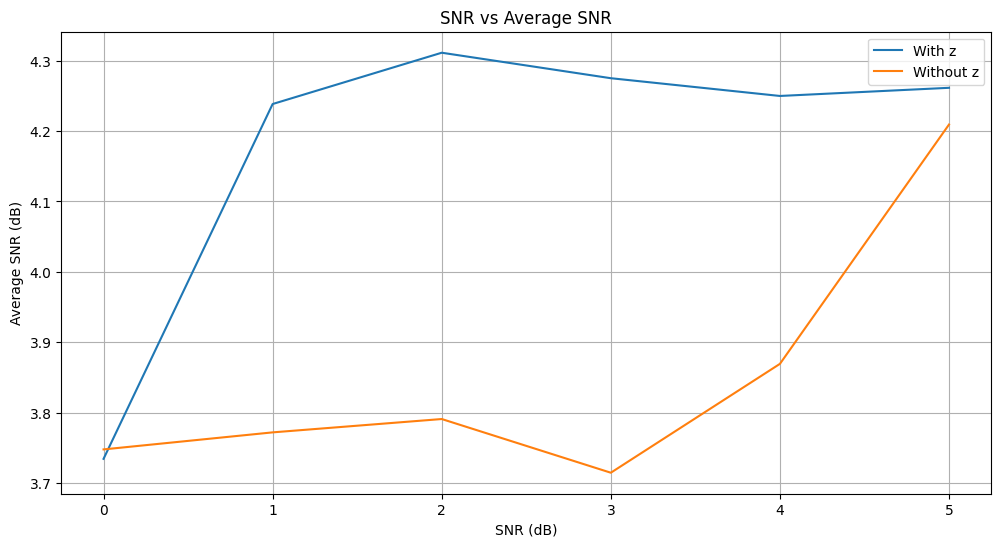

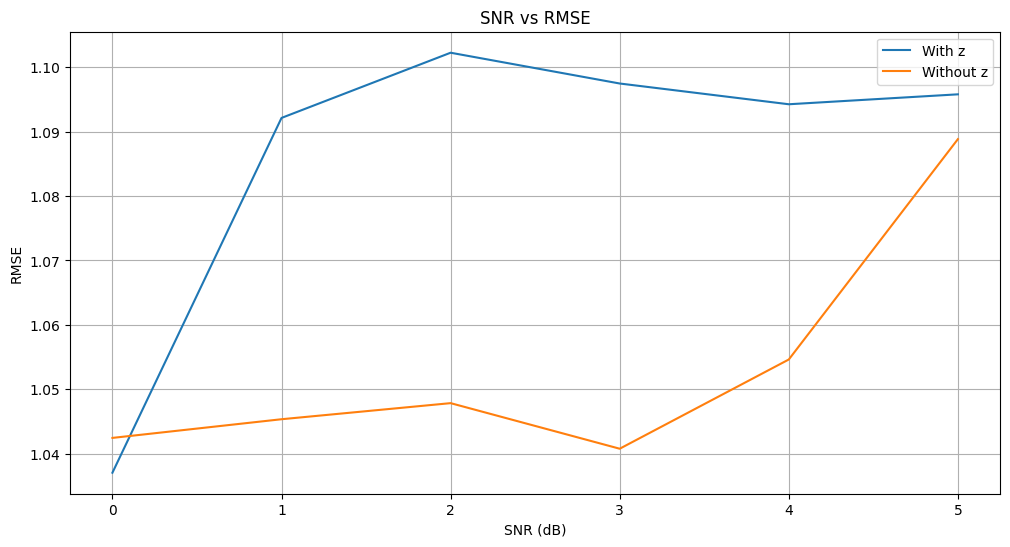

ModuleNotFoundError: No module named 'ace_tools'

In [1]:
import numpy as np
import wfdb
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import matplotlib.pyplot as plt

# Define the ECGDataset class
class ECGDataset(Dataset):
    def __init__(self, raw_signals, noisy_signals):
        self.raw_signals = raw_signals
        self.noisy_signals = noisy_signals

    def __len__(self):
        return len(self.raw_signals)

    def __getitem__(self, idx):
        raw_signal = self.raw_signals[idx]
        noisy_signal = self.noisy_signals[idx]
        return torch.tensor(raw_signal, dtype=torch.float32), torch.tensor(noisy_signal, dtype=torch.float32)

# Define the add_noise function
def add_noise(signal, noise, snr):
    signal_power = np.mean(signal ** 2)
    noise_power = np.mean(noise ** 2)
    factor = 10 * ((signal_power / noise_power) / (10 ** (snr / 10)))
    noisy_signal = 100 * (signal + noise * np.sqrt(factor))
    return noisy_signal

# Define the load_mit_bih_data function
def load_mit_bih_data(records, noise_type, snr_levels, target_length=650000):
    raw_signals = []
    noisy_signals_dict = {snr: [] for snr in snr_levels}
    
    for record in records:
        raw_record = wfdb.rdrecord(f'M:\Dissertation\\New folder\\mit-bih-arrhythmia-database-1.0.0/{record}')
        raw_signal = raw_record.p_signal[:, 0]  # Use the first channel for simplicity
        
        # Load noise and add it to the raw signal
        noise_record = wfdb.rdrecord(f'M:\Dissertation\\New folder\\mit-bih-noise-stress-test-database-1.0.0/{noise_type}')
        noise_signal = noise_record.p_signal[:, 0]
        
        # Ensure the signals are of the same length
        min_length = min(len(raw_signal), len(noise_signal), target_length)
        raw_signal = raw_signal[:min_length]
        noise_signal = noise_signal[:min_length]
        
        # Pad signals to target length
        if min_length < target_length:
            raw_signal = np.pad(raw_signal, (0, target_length - min_length), 'constant')
            noise_signal = np.pad(noise_signal, (0, target_length - min_length), 'constant')
        
        raw_signals.append(raw_signal)
        
        for snr in snr_levels:
            noisy_signal = add_noise(raw_signal, noise_signal, snr)
            noisy_signals_dict[snr].append(noisy_signal)
    
    return np.array(raw_signals), {snr: np.array(noisy_signals_dict[snr]) for snr in snr_levels}

# Select records and noise types for the experiment
records = ['103', '105', '111', '116', '122', '205', '213', '219', '223', '230']
noise_types = ['bw', 'em', 'ma']
combined_noise_types = ['em+bw', 'ma+bw', 'ma+em', 'ma+em+bw']
snr_levels = [0, 1, 2, 3, 4, 5]
target_length = 649984

raw_signals, noisy_signals_dict = {}, {}
for noise_type in noise_types:
    raw_signals[noise_type], noisy_signals_dict[noise_type] = load_mit_bih_data(records, noise_type, snr_levels, target_length)

# For combined noise types, combine the corresponding noises
for combined_noise in combined_noise_types:
    components = combined_noise.split('+')
    combined_raw_signals, combined_noisy_signals = [], {snr: [] for snr in snr_levels}
    for i in range(len(records)):
        combined_signal = np.zeros(target_length)
        for component in components:
            raw_signal = raw_signals[component][i]
            combined_signal += raw_signal / len(components)  # Average the signals
        combined_raw_signals.append(combined_signal)
        for snr in snr_levels:
            combined_noise_signal = np.zeros(target_length)
            for component in components:
                noise_signal = noisy_signals_dict[component][snr][i]
                combined_noise_signal += noise_signal / len(components)  # Average the noises
            combined_noisy_signals[snr].append(combined_noise_signal)
    raw_signals[combined_noise] = np.array(combined_raw_signals)
    noisy_signals_dict[combined_noise] = {snr: np.array(combined_noisy_signals[snr]) for snr in snr_levels}

# Create datasets and dataloaders
datasets = {}
for noise_type in noise_types + combined_noise_types:
    for snr in snr_levels:
        datasets[(noise_type, snr)] = ECGDataset(raw_signals[noise_type], noisy_signals_dict[noise_type][snr])

dataloaders = {key: DataLoader(dataset, batch_size=16, shuffle=True) for key, dataset in datasets.items()}

# Define the Generator class
class Generator(nn.Module):
    def __init__(self, use_z=True):
        super(Generator, self).__init__()
        self.use_z = use_z
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 8, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(8, 16, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(16, 32, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(512, 1024, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.decoder_with_z = nn.Sequential(
            nn.ConvTranspose1d(2048, 1024, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(1024, 512, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(16, 8, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(8, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )
        self.decoder_without_z = nn.Sequential(
            nn.ConvTranspose1d(1024, 512, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(16, 8, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(8, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        if self.use_z:
            z = torch.randn_like(encoded)
            encoded = torch.cat((encoded, z), 1)
            decoded = self.decoder_with_z(encoded)
        else:
            decoded = self.decoder_without_z(encoded)
        return decoded

# Define the Discriminator class
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv1d(2, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(512, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x).view(x.size(0), -1)

# Define the calculate_snr function
def calculate_snr(original, denoised):
    noise = original - denoised
    snr = abs(10 * np.log10(np.sum(original ** 2) / np.sum(noise ** 2)))
    return snr

def calculate_rmse(original, denoised):
    mse = np.mean((original - denoised) ** 2)
    rmse = np.sqrt(mse)
    return rmse

def train(generator, discriminator, dataloaders, num_epochs=1, lr=0.0005):
    criterion = nn.BCELoss()
    optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    results = {'Noise_Type': [], 'SNR_Level': [], 'Epoch': [], 'Batch': [], 'D_loss': [], 'G_loss': [], 'SNR': [], 'RMSE': []}
    
    for (noise_type, snr), dataloader in dataloaders.items():
        for epoch in range(num_epochs):
            for i, (raw_signals, noisy_signals) in enumerate(dataloader):
                batch_size = raw_signals.size(0)
                
                # Ensure the signals have the same length
                min_length = min(raw_signals.shape[-1], noisy_signals.shape[-1])
                raw_signals = raw_signals[:, :min_length]
                noisy_signals = noisy_signals[:, :min_length]

                # Denoise the noisy signals
                noisy_signals = noisy_signals.unsqueeze(1)  # Add channel dimension
                raw_signals = raw_signals.unsqueeze(1)

                # Train Generator
                optimizer_G.zero_grad()
                gen_signals = generator(noisy_signals)
                
                # Ensure the generated signals have the same length as the input signals
                if gen_signals.shape[-1] != noisy_signals.shape[-1]:
                    gen_signals = torch.nn.functional.interpolate(gen_signals, size=noisy_signals.shape[-1])

                # Update valid and fake labels to match the discriminator output size
                disc_output_size = discriminator(torch.cat((gen_signals, noisy_signals), 1)).size()
                valid = torch.ones(disc_output_size).to(gen_signals.device)
                fake = torch.zeros(disc_output_size).to(gen_signals.device)
                
                g_loss = criterion(discriminator(torch.cat((gen_signals, noisy_signals), 1)), valid)
                g_loss.backward()
                optimizer_G.step()

                # Train Discriminator
                optimizer_D.zero_grad()
                real_loss = criterion(discriminator(torch.cat((raw_signals, noisy_signals), 1)), valid)
                fake_loss = criterion(discriminator(torch.cat((gen_signals.detach(), noisy_signals), 1)), fake)
                d_loss = (real_loss + fake_loss) * 10
                d_loss.backward()
                optimizer_D.step()
                
                # Calculate SNR and RMSE
                snr_value = calculate_snr(raw_signals.squeeze().cpu().numpy(), gen_signals.squeeze().cpu().detach().numpy())
                rmse_value = calculate_rmse(raw_signals.squeeze().cpu().numpy(), gen_signals.squeeze().cpu().detach().numpy())

                # Store results
                results['Noise_Type'].append(noise_type)
                results['SNR_Level'].append(snr)
                results['Epoch'].append(epoch + 1)
                results['Batch'].append(i + 1)
                results['D_loss'].append(d_loss.item())
                results['G_loss'].append(g_loss.item())
                results['SNR'].append(snr_value)
                results['RMSE'].append(rmse_value)
                
                print(f"[{'With z' if generator.use_z else 'Without z'}] [{noise_type} SNR {snr}] [Epoch {epoch + 1}/{num_epochs}] [Batch {i + 1}/{len(dataloader)}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}] [SNR: {snr_value}] [RMSE: {rmse_value}]")

    return results

# Initialize models with and without z
generator_with_z = Generator(use_z=True)
generator_without_z = Generator(use_z=False)
discriminator = Discriminator()

# Train the models and collect results for each SNR level
results_with_z = train(generator_with_z, discriminator, dataloaders, num_epochs=1)  # Adjusted for quick testing
results_without_z = train(generator_without_z, discriminator, dataloaders, num_epochs=1)  # Adjusted for quick testing

# Create DataFrames to display results
df_results_with_z = pd.DataFrame(results_with_z)
df_results_without_z = pd.DataFrame(results_without_z)

# Average SNR and RMSE for each SNR level
avg_snr_with_z = df_results_with_z.groupby('SNR_Level')['SNR'].mean()
avg_rmse_with_z = df_results_with_z.groupby('SNR_Level')['RMSE'].mean()

avg_snr_without_z = df_results_without_z.groupby('SNR_Level')['SNR'].mean()
avg_rmse_without_z = df_results_without_z.groupby('SNR_Level')['RMSE'].mean()

# Plot SNR vs Average SNR
plt.figure(figsize=(12, 6))
plt.plot(avg_snr_with_z.index, avg_snr_with_z.values, label='With z')
plt.plot(avg_snr_without_z.index, avg_snr_without_z.values, label='Without z')
plt.xlabel('SNR (dB)')
plt.ylabel('Average SNR (dB)')
plt.title('SNR vs Average SNR')
plt.legend()
plt.grid(True)
plt.savefig('snr_vs_avg_snr.png')
plt.show()

# Plot SNR vs RMSE
plt.figure(figsize=(12, 6))
plt.plot(avg_rmse_with_z.index, avg_rmse_with_z.values, label='With z')
plt.plot(avg_rmse_without_z.index, avg_rmse_without_z.values, label='Without z')
plt.xlabel('SNR (dB)')
plt.ylabel('RMSE')
plt.title('SNR vs RMSE')
plt.legend()
plt.grid(True)
plt.savefig('snr_vs_rmse.png')
plt.show()

# Display the DataFrames as a table
import ace_tools as tools
tools.display_dataframe_to_user(name="Denoising Results with z", dataframe=df_results_with_z)
tools.display_dataframe_to_user(name="Denoising Results without z", dataframe=df_results_without_z)
